# ResNet50 TransferLearning 2048 - PoC

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [2]:
# Dwie klasy lepsze od 1!
NUM_CLASSES = 2

# 3 kanały koloru
CHANNELS = 3

# Wielkość ResNetu
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

BATCH_SIZE_TESTING = 1

In [3]:
from keras.applications.resnet import ResNet50
from keras.layers import Dense
from keras.models import Sequential
import keras

Using TensorFlow backend.


In [4]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

model.layers[0].trainable = False

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [6]:
from keras import optimizers

opt = optimizers.Adam()
model.compile(optimizer = 'adadelta', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [7]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

path = '../../MGU/Projekt/PS-Battles-master/' if os.name != 'nt' else '..\\..\\MGU\\Data\\CatsDogs'
slash = '/' if os.name != 'nt' else '\\'

train_generator = data_generator.flow_from_directory(
        directory=path + slash + 'test' + slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        directory=path + slash + 'valid'+ slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 200, 100, 50)

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '..' + slash + 'working' + slash + 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [10]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights('..' + slash + 'working' + slash + 'best.hdf5')

Epoch 1/10
10/10 [==============================] - 231s 23s/step - loss: 0.7061 - accuracy: 0.5600 - val_loss: 1.4723 - val_accuracy: 0.5770
Epoch 2/10
10/10 [==============================] - 218s 22s/step - loss: 0.6693 - accuracy: 0.7970 - val_loss: 0.0648 - val_accuracy: 0.9660
Epoch 3/10
10/10 [==============================] - 217s 22s/step - loss: 0.2080 - accuracy: 0.9270 - val_loss: 0.0850 - val_accuracy: 0.9660
Epoch 4/10
10/10 [==============================] - 218s 22s/step - loss: 0.1783 - accuracy: 0.9360 - val_loss: 0.1073 - val_accuracy: 0.9690
Epoch 5/10
10/10 [==============================] - 224s 22s/step - loss: 0.0736 - accuracy: 0.9730 - val_loss: 0.1043 - val_accuracy: 0.9680


In [11]:
# model.save('..' + slash + 'working' + slash + 'DogsCatsPoC.h5')

In [12]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


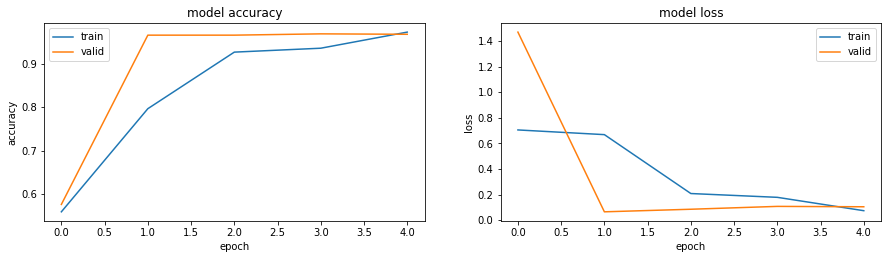

In [13]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [14]:
test_generator = data_generator.flow_from_directory(
    directory = path + slash + 'show' + slash,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 50 images belonging to 1 classes.


In [15]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

50/50 [==============================] - 7s 149ms/step


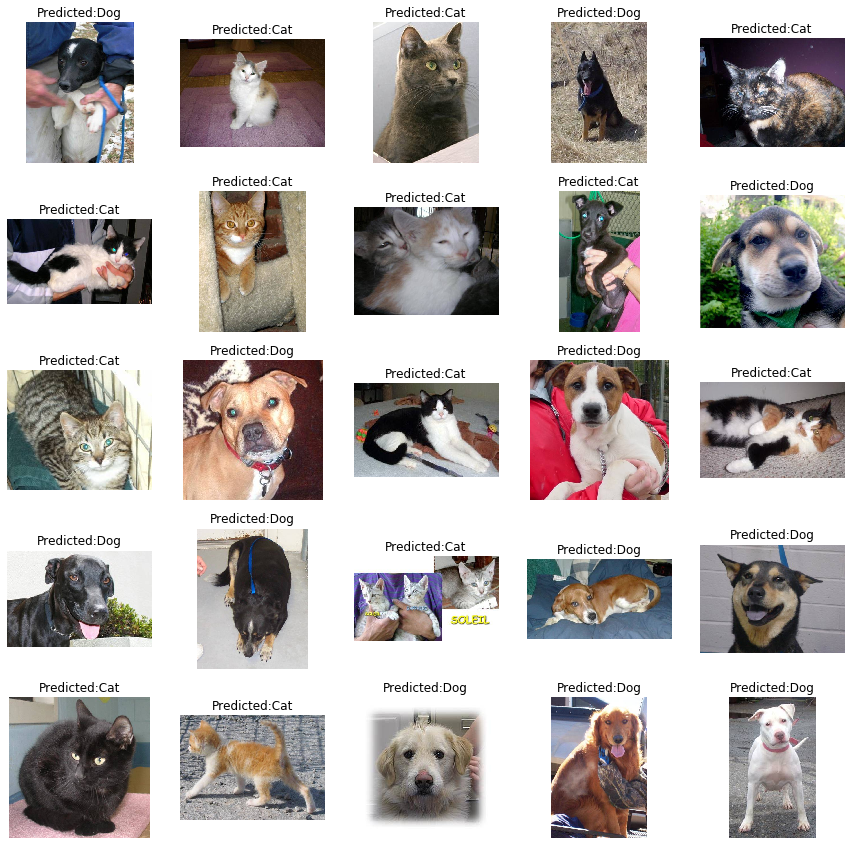

In [16]:
TEST_DIR = path + slash + 'show' + slash
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()